In [1]:
import pandas as pd
import glob, os, sys
import xml.etree.ElementTree as ET
from tqdm import tqdm_notebook as tqdm
sys.path.append('../scripts/')
import util
import parsing_util
from importlib import reload
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import consensus_score
import json
from collections import defaultdict

In [54]:
reload(parsing_util)

<module 'parsing_util' from '../scripts\\parsing_util.py'>

# Read in Data

In [40]:
stanford_dir = "../data/news-article-flatlist/stanford-parses/"

In [41]:
stanford_parses = glob.glob(os.path.join(stanford_dir, '*'))
all_docs = {}
all_sources = defaultdict(list)
for xml_file in tqdm(stanford_parses):
    doc_id, sources, sents_list, lemmas, named_ents_list, deps = parsing_util.parse_stanford_and_get_people(xml_file)
    all_docs[doc_id] = ' '.join([' '.join(sent) for sent in sents_list])
                                
    for name, source_info in sources.items():
        first_mention = ' '.join(sents_list[source_info['first_mention'].sentence])
        speaking_sents = []
        for speaking_vb in source_info['speaking_vbs']:
            speaking_sents.append(' '.join(sents_list[speaking_vb['sentence']]))
        all_sources[name].append(first_mention + ' ' + ' '.join(speaking_sents))
    break

In [5]:
source_mat = pd.Series(all_sources).loc[lambda s: s.str.len() < 6].str.join(' ')
doc_mat = pd.Series(all_docs)

# Do Bi-Clustering

In [49]:
tfidf = TfidfVectorizer(max_df=.4, min_df=.001, analyzer='char', ngram_range=(1,3))
tfidf_vecs = tfidf.fit_transform(pd.concat([source_mat, doc_mat]))
source_vec = tfidf_vecs[:len(source_mat)]
doc_vec = tfidf_vecs[len(source_mat):]

In [66]:
source_doc_sim = source_vec.dot(doc_vec.T)

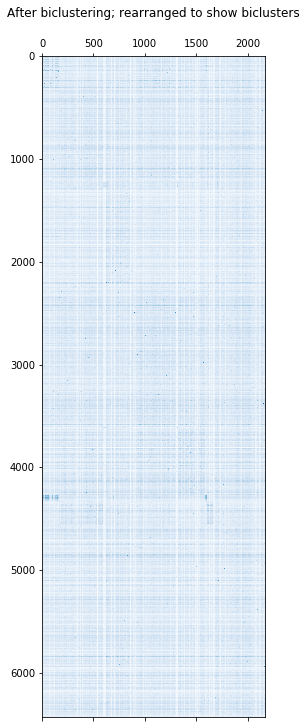

In [157]:
model = SpectralCoclustering(n_clusters=10, random_state=0)
model.fit(source_doc_sim)
# score = consensus_score(model.biclusters_, (rows[:, row_idx], columns[:, col_idx]))
# print("consensus score: {:.3f}".format(score))

fit_data = source_doc_sim[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data.todense(), cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

plt.show()

In [158]:
source_mat_with_labels = source_mat.to_frame('text').assign(clusters=model.row_labels_)

In [209]:
import pyperclip

In [210]:
pd.options.display.max_colwidth=500

pyperclip.copy((source_mat_with_labels
 .loc[lambda df: df['clusters']==3]
).sample(5)['text'].to_latex())

In [160]:
doc_mat_with_labels = doc_mat.to_frame('text').assign(cluster=model.column_labels_)

In [216]:
pyperclip.copy((doc_mat_with_labels
    .loc[lambda df: df['cluster'] == 3]
).head(3)['text'].to_latex(index=False))

# Check against manual tags

In [162]:
tagged_files = glob.glob('../app/data/*-marke*')
tags = []
for f in tagged_files:
    tags.extend(json.load(open(f)))

tags_df = pd.DataFrame(tags)
legit_tagged_sources = (
    tags_df
        .groupby('person')[['question_class', 'label']]
        .apply(lambda df: dict(df.itertuples(index=False)))
        .apply(pd.Series)
        .fillna('')
        .loc[lambda df: df['error'] == 'legit']
)

legit_tagged_sources = (
    legit_tagged_sources
        .reset_index()
        .assign(person=lambda df: df['person'].str.replace('-', ' '))
        .set_index('person')
)

In [163]:
affil = legit_tagged_sources['affiliation']
role = (legit_tagged_sources
     .loc[:, list(filter(lambda x: 'person-role' in x, legit_tagged_sources.columns))]
     .apply(lambda x: x.loc[lambda y: y!=''][0], axis=1)
)

In [188]:
from collections import Counter
import seaborn as sns

In [200]:
fig_dir = 'C:/Users/alexa/OneDrive/Documents/usc-research/status-updates/2019-10-12/figures/'

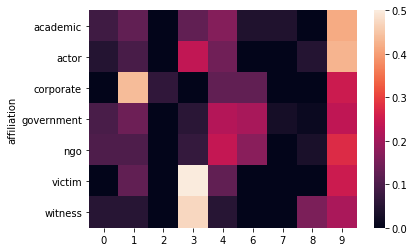

In [201]:
source_affil_check = source_mat_with_labels.merge(affil.to_frame(), left_index=True, right_index=True)
source_affil_mat = (
    source_affil_check[['clusters', 'affiliation']]
        .groupby('affiliation')['clusters']
        .apply(Counter)
        .unstack()
        .fillna(0)
        .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
)
sns.heatmap(source_affil_mat)
plt.savefig(os.path.join(fig_dir, 'affil-agreement.pdf'), bbox_inches="tight")
# plt.yticks(range(len(source_affil_mat)), source_affil_mat.index)
# plt.legend()

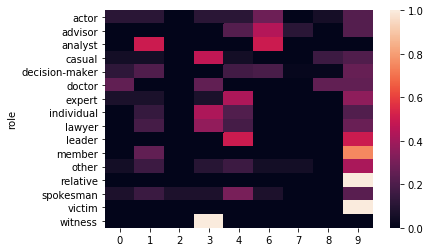

In [202]:
source_role_check = source_mat_with_labels.merge(role.to_frame('role'), left_index=True, right_index=True)
source_role_mat = (source_role_check[['clusters', 'role']]
 .groupby('role')['clusters']
 .apply(Counter)
 .unstack()
 .fillna(0)
 .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
)

sns.heatmap(source_role_mat)
plt.savefig(os.path.join(fig_dir, 'role-agreement.pdf'), bbox_inches="tight")